# Dynamical systems example in numpyro

## Debug

## Setup

### Import libraries

In [1]:
import time as time_module
start_time = time_module.time()

In [2]:
import platform
from inspect import getmembers
from pprint import pprint
from types import FunctionType

import arviz as az
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist

In [3]:
from jax.experimental.ode import odeint
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive
from diffrax import (
    diffeqsolve,
    ODETerm,
    Tsit5,
    Dopri5,
    BacksolveAdjoint,
    SaveAt,
    PIDController,
)

In [4]:
jax.config.update("jax_enable_x64", True)
numpyro.util.enable_x64()

In [5]:
import warnings

warnings.filterwarnings("ignore")

In [6]:
numpyro.set_platform("cpu")
numpyro.set_host_device_count(8)

In [7]:
print(platform.python_version())
print(numpyro.__version__)
print(jax.__version__)
print(az.__version__)

3.10.12
0.12.1
0.4.11
0.15.1


In [8]:
print("JAX backend:", jax.devices())

JAX backend: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


### Setup plotting

In [9]:
import matplotlib.font_manager
import matplotlib.pyplot as plt

# import matplotlib_inline

In [10]:
fonts_path = "/usr/share/texmf/fonts/opentype/public/lm/"  # ubuntu
# fonts_path = "~/Library/Fonts/" # macos
# fonts_path = "/usr/share/fonts/OTF/"  # arch
matplotlib.font_manager.fontManager.addfont(fonts_path + "lmsans10-regular.otf")
matplotlib.font_manager.fontManager.addfont(fonts_path + "lmroman10-regular.otf")

In [11]:
# https://stackoverflow.com/a/36622238/446907
%config InlineBackend.figure_formats = ['svg']

In [12]:
plt.style.use("default")  # reset default parameters
# https://stackoverflow.com/a/3900167/446907
plt.rcParams.update(
    {
        "font.size": 16,
        "font.family": ["sans-serif"],
        "font.serif": ["Latin Modern Roman"] + plt.rcParams["font.serif"],
        "font.sans-serif": ["Latin Modern Sans"] + plt.rcParams["font.sans-serif"],
    }
)

### Utility functions

In [13]:
def attributes(obj):
    disallowed_names = {
        name for name, value in getmembers(type(obj)) if isinstance(value, FunctionType)
    }
    return {
        name: getattr(obj, name)
        for name in dir(obj)
        if name[0] != "_" and name not in disallowed_names and hasattr(obj, name)
    }


def print_attributes(obj):
    pprint(attributes(obj))

## Execute

### Load sample data

In [14]:
_, fetch = load_dataset(LYNXHARE, shuffle=False)
year, original_data = fetch()  # data is in hare -> lynx order
print(type(year), year.shape, year.dtype)
print(type(original_data), original_data.shape, original_data.dtype)

<class 'jaxlib.xla_extension.ArrayImpl'> (91,) int64
<class 'jaxlib.xla_extension.ArrayImpl'> (91, 2) float64


### Define model

#### Qualitative analysis

The Lotka-Volterra model is a set of ordinary differential equations (ODEs) that describes the dynamics of predator-prey interactions:

$$
\frac{du}{dt} = \alpha u - \beta uv,
$$
$$
\frac{dv}{dt} = -\gamma v + \delta uv.
$$

Here, $u$ is the number of prey, $v$ is the number of predators, $\alpha$ is the prey's birth rate, $\beta$ is the rate at which predators consume prey, $\gamma$ is the predators' death rate, and $\delta$ is the rate at which predators increase their population by consuming prey.

The system is capable of exhibiting oscillatory behavior. We can find the fixed points by setting the derivatives equal to zero and solving for $u$ and $v$. Doing so yields $(0, 0)$ and $\left(\frac{\gamma}{\delta}, \frac{\alpha}{\beta}\right)$ as the fixed points. The second fixed point is a center in the phase plane, around which the trajectories are closed orbits.

Dividing the equations, we find

$$
\frac{du}{dv} = \frac{\alpha u - \beta uv}{- \gamma v + \delta uv} = \frac{\alpha}{\gamma} - \left(\frac{\beta}{\gamma} + \frac{\alpha}{\gamma}\right)\frac{v}{u}.
$$

This equation represents a family of trajectories in the $(u, v)$ phase space, which are closed orbits. This is consistent with the observation that the solutions of the Lotka-Volterra system are periodic.

The non-dimensionalized system can be rewritten as:

$$
\frac{dU}{d\tau} = (\bar{\alpha} - \bar{\beta} V) U,
$$
$$
\frac{dV}{d\tau} = (-\bar{\gamma} + \bar{\delta} U) V.
$$

Here, $U = \frac{u}{U_0}$, $V = \frac{v}{V_0}$, and $\tau = \frac{t}{T}$. Also, $\bar{\alpha} = \frac{\alpha T}{U_0}$, $\bar{\beta} = \beta V_0 T$, $\bar{\gamma} = \frac{\gamma T}{V_0}$, and $\bar{\delta} = \delta U_0 T$.

The original parameters can be computed via descaling:

$$
\alpha = \frac{\bar{\alpha}U_0}{T},
$$
$$
\gamma = \frac{\bar{\gamma}V_0}{T},
$$
$$
\beta = \frac{\bar{\beta}}{V_0 T},
$$
$$
\delta = \frac{\bar{\delta}}{U_0 T}.
$$

If the rescaled data support amplitudes $M \approx (0.05, 3.5)$ and period $P \approx 10$, we can substitute various choices for the non-dimensionalized constants, and then choose convenient values for $U_0$, $V_0$, and $T$ (e.g. $U_0 = V_0 = 1$, $T = 1$) to obtain the original parameters $\alpha$, $\beta$, $\gamma$, and $\delta$.


#### Rescale data

In [15]:
from scipy.signal import find_peaks


def rescale_data(year, data):
    year_np = np.array(year)
    data_np = np.array(data)

    U = data[:, 0]
    V = data[:, 1]

    U_0 = jnp.mean(U)
    V_0 = jnp.mean(V)

    # Estimate T as the average period between peaks
    peaks, _ = find_peaks(data_np[:, 0])
    if len(peaks) > 1:
        periods = np.diff(year_np[peaks])
        T = np.mean(periods)
    else:
        T = 1.0

    # Transform U, V, and time
    T = jnp.array(T)
    U_transformed = U / U_0
    V_transformed = V / V_0
    time_transformed = (year - year[0]) / T

    data_transformed = jnp.stack((U_transformed, V_transformed), axis=-1)

    return U_0, V_0, T, time_transformed, data_transformed

In [16]:
U_0, V_0, T, time, rescaled_data = rescale_data(year, original_data)
data = rescaled_data
print(f"U_0: {U_0:0.2f}, V_0: {V_0}, T: {T}")
print(type(year), year.shape, year.dtype)
print(type(data), data.shape, data.dtype)

U_0: 45.41, V_0: 28.336593406593405, T: 6.615384615384615
<class 'jaxlib.xla_extension.ArrayImpl'> (91,) int64
<class 'jaxlib.xla_extension.ArrayImpl'> (91, 2) float64


In [17]:
type(time), time.shape, time.dtype

(jaxlib.xla_extension.ArrayImpl, (91,), dtype('float64'))

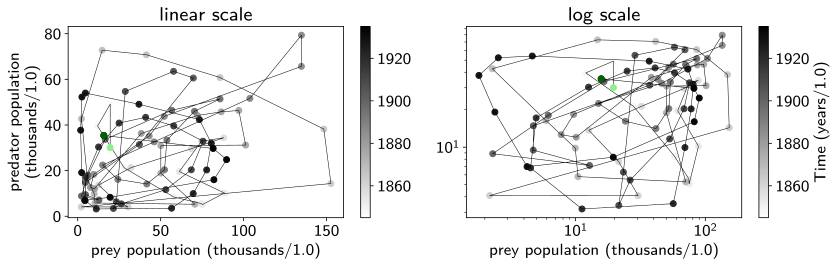

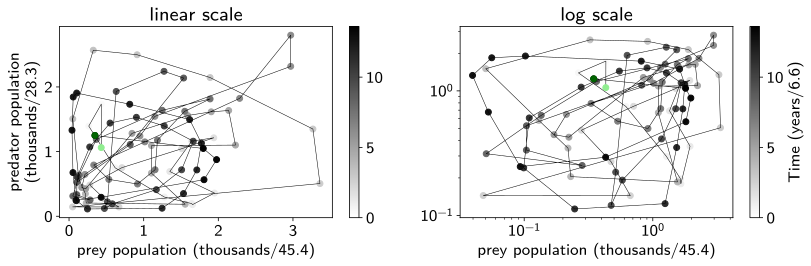

In [18]:
def plot_phase_portrait(data, time, is_ode_solution=False, U_0=1.0, V_0=1.0, T=1.0):
    
    if is_ode_solution:
        prey, predator = data.ys[0], data.ys[1]
    else:
        prey, predator = data[:, 0], data[:, 1]
    
    # norm_time = (time - np.min(time)) / (np.max(time) - np.min(time))
    norm_time = time

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sc = axes[0].scatter(prey, predator, c=norm_time, cmap="gray_r", label="Phase Portrait")
    axes[0].plot(prey, predator, color='black', linewidth=0.5)
    axes[0].scatter(prey[0], predator[0], c='lightgreen', label="Initial time", zorder=5)
    axes[0].scatter(prey[-1], predator[-1], c='darkgreen', label="Final time", zorder=5)
    axes[0].set_xlabel(f"prey population (thousands/{U_0:.1f})")
    axes[0].set_ylabel(f"predator population\n(thousands/{V_0:.1f})")
    axes[0].set_title('linear scale')
    plt.colorbar(sc, ax=axes[0], label='')

    sc = axes[1].scatter(prey, predator, c=norm_time, cmap="gray_r", label="Phase Portrait")
    axes[1].plot(prey, predator, color='black', linewidth=0.5)
    axes[1].scatter(prey[0], predator[0], c='lightgreen', label="Initial time", zorder=5)
    axes[1].scatter(prey[-1], predator[-1], c='darkgreen', label="Final time", zorder=5)
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
    axes[1].set_xlabel(f"prey population (thousands/{U_0:.1f})")
    # axes[1].set_ylabel(f"predator population\n(thousands/{V_0:.1f})")
    axes[1].set_title('log scale')
    plt.colorbar(sc, ax=axes[1], label=f"Time (years/{T:.1f})")

    plt.tight_layout()
    plt.show()

plot_phase_portrait(original_data, year, is_ode_solution=False)
plot_phase_portrait(data, time, is_ode_solution=False, U_0=U_0, V_0=V_0, T=T)

#### Simulate individual trajectories

In [19]:
def dz_dt_diffrax(t, z, theta):
    """
    Lotka–Volterra equations. Real positive parameters `alpha`, `beta`, `gamma`, `delta`
    describes the interaction of two species.
    """
    u, v = z
    alpha, beta, gamma, delta = theta
    du = (alpha - beta * v) * u
    dv = (-gamma + delta * u) * v
    d_z = du, dv
    return d_z

def dz_dt(z, t, theta):
    """
    Lotka–Volterra equations. Real positive parameters `alpha`, `beta`, `gamma`, `delta`
    describes the interaction of two species.
    """
    u, v = z
    alpha, beta, gamma, delta = theta
    du = (alpha - beta * v) * u
    dv = (-gamma + delta * u) * v
    d_z = du, dv
    return d_z

In [20]:
@jax.jit
def solve_lv_model(ts, z_init, theta, N=None):
    term = ODETerm(dz_dt_diffrax)
    t0 = 0.0
    # t1 = N
    t1 = jnp.max(ts)
    dt0 = 0.01
    saveat = SaveAt(ts=ts)
    # stepsize_controller = PIDController(rtol=1e-6, atol=1e-5)
    stepsize_controller = PIDController(rtol=1e-7, atol=1e-7)

    y0 = tuple(z_init)
    args = tuple(theta)

    solution = diffeqsolve(
        term,
        # solver=Dopri5(),
        solver=Tsit5(),
        t0=t0,
        t1=t1,
        dt0=dt0,
        y0=y0,
        args=args,
        saveat=saveat,
        stepsize_controller=stepsize_controller,
        # adjoint=BacksolveAdjoint(),
        max_steps=int(1e4),
        throw=False,
    )

    return solution

In [21]:
y0 = (2.5, 0.5)
args = (5.0, 3.0, 5.0, 3.0)
solution = solve_lv_model(time, y0, args)

In [22]:
def descale_parameters(args, U0, V0, T):
    # extract input parameters
    bar_alpha, bar_beta, bar_gamma, bar_delta = args

    # convert rescaled parameters to original parameters
    alpha = (bar_alpha * U0) / T
    gamma = (bar_gamma * V0) / T
    beta = bar_beta / (V0 * T)
    delta = bar_delta / (U0 * T)

    # return the converted parameters
    return alpha, beta, gamma, delta


def rescale_parameters(args, U0, V0, T):
    # extract input parameters
    alpha, beta, gamma, delta = args

    # convert original parameters to rescaled parameters
    bar_alpha = (alpha * T) / U0
    bar_gamma = (gamma * T) / V0
    bar_beta = beta * V0 * T
    bar_delta = delta * U0 * T

    # return the rescaled parameters
    return bar_alpha, bar_beta, bar_gamma, bar_delta

In [23]:
alpha, beta, gamma, delta = descale_parameters(args, U_0, V_0, T)
print(
    f"Descaled paramerters:\n  "
    f"alpha: {alpha:.1f}, "
    f"beta: {beta:.5f}, "
    f"gamma: {gamma:.1f}, "
    f"delta: {delta:.5f}"
)

rescaled_args = rescale_parameters((alpha, beta, gamma, delta), U_0, V_0, T)
print(
    f"Rescaled Parameters:\n  "
    f"bar_alpha: {rescaled_args[0]:.1f}, "
    f"bar_beta: {rescaled_args[1]:.2f}, "
    f"bar_gamma: {rescaled_args[2]:.1f}, "
    f"bar_delta: {rescaled_args[3]:.2f}"
)

Descaled paramerters:
  alpha: 34.3, beta: 0.01600, gamma: 21.4, delta: 0.00999
Rescaled Parameters:
  bar_alpha: 5.0, bar_beta: 3.00, bar_gamma: 5.0, bar_delta: 3.00


In [24]:
def plot_ode_solution(solution):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(solution.ts, solution.ys[0], label="prey", marker=".", ms=12, color="green")
    axes[0].plot(solution.ts, solution.ys[1], label="predator", marker=".", ms=12, color="gray")
    axes[0].set_xlabel(f"time (years/{T:.2f})")
    axes[0].set_ylabel(f"population\n(thousands/{U_0:.1f} and {V_0:.1f})")
    # axes[0].legend(loc="best")
    axes[0].set_title('linear scale')

    axes[1].plot(solution.ts, solution.ys[0], label="prey", marker=".", ms=12, color="green")
    axes[1].plot(solution.ts, solution.ys[1], label="predator", marker=".", ms=12, color="gray")
    axes[1].set_yscale('log')
    axes[1].set_xlabel(f"time (years/{T:.2f})")
    axes[1].set_ylabel(f"population\n(thousands/{U_0:.1f} and {V_0:.1f})")
    axes[1].set_ylim(10**-2, 10**1)
    axes[1].legend(loc="lower right")
    axes[1].set_title('log scale')

    # Show plot
    plt.tight_layout()
    plt.show()


In [25]:
type(solution.ys)

tuple

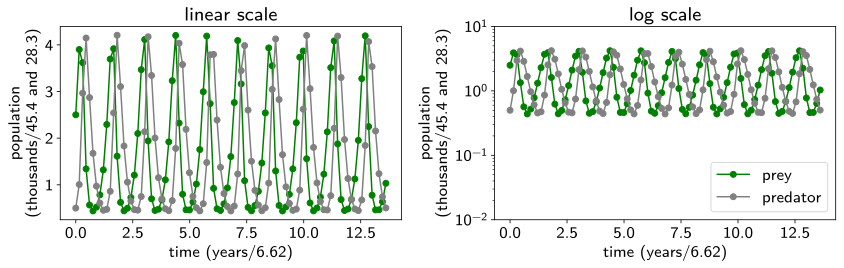

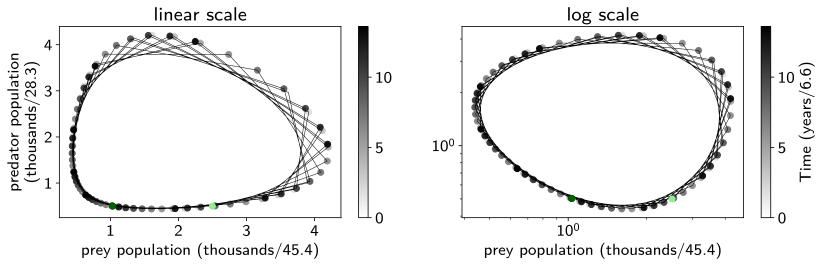

In [26]:
plot_ode_solution(solution)
plot_phase_portrait(solution, time, is_ode_solution=True, U_0=U_0, V_0=V_0, T=T)

#### Define probabilistic model

We would like to estimate the parameters for `dist.LogNormal` that will lead to only 5% of the probability mass greater than 0.5. We can solve this problem analytically. Let's say the parameters of the `LogNormal` distribution are $\mu$ and $\sigma$. We are looking for values of $\mu$ and $\sigma$ such that:

$$P(X > 0.5) = 0.05$$

where $X$ follows a LogNormal distribution with parameters $\mu$ and $\sigma$. The cumulative distribution function (CDF) of the LogNormal distribution is:

$$P(X \le x) = \frac{1}{2} + \frac{1}{2} \text{erf}\left(\frac{\ln(x) - \mu}{\sqrt{2} \sigma}\right)$$

So, the probability that $X$ is greater than 0.5 can be written as:

$$P(X > 0.5) = 1 - P(X \le 0.5) = 1 - \left(\frac{1}{2} + \frac{1}{2} \text{erf}\left(\frac{\ln(0.5) - \mu}{\sqrt{2} \sigma}\right)\right) = 0.05$$

In [27]:
from scipy.optimize import fsolve
from scipy.special import erf


def tail_probability_equation(mu, sigma, threshold, upper_tail_mass):
    return (
        1 - (0.5 + 0.5 * erf((np.log(threshold) - mu) / (np.sqrt(2) * sigma)))
    ) - upper_tail_mass


def solve_lognormal_parameters(threshold, upper_tail_mass, mu=None, sigma=None):
    if mu is not None:
        # Solve for sigma
        def equation_to_solve(sigma):
            return tail_probability_equation(mu, sigma, threshold, upper_tail_mass)

        sigma = fsolve(equation_to_solve, 1)[0]
        return mu, sigma

    elif sigma is not None:
        # Solve for mu
        def equation_to_solve(mu):
            return tail_probability_equation(mu, sigma, threshold, upper_tail_mass)

        mu = fsolve(equation_to_solve, 0)[0]
        return mu, sigma

    else:
        raise ValueError("Either mu or sigma must be provided.")

In [28]:
mu, sigma = solve_lognormal_parameters(threshold=0.5, upper_tail_mass=0.05, sigma=1)
print("mu:", mu)
print("sigma:", sigma)


mu, sigma = solve_lognormal_parameters(
    threshold=jnp.log(7), upper_tail_mass=0.05, mu=jnp.log(2)
)
print("mu:", mu)
print("sigma:", sigma)

mu: -2.3380008075114183
sigma: 1
mu: 0.6931471805599453
sigma: 5449.77359812945


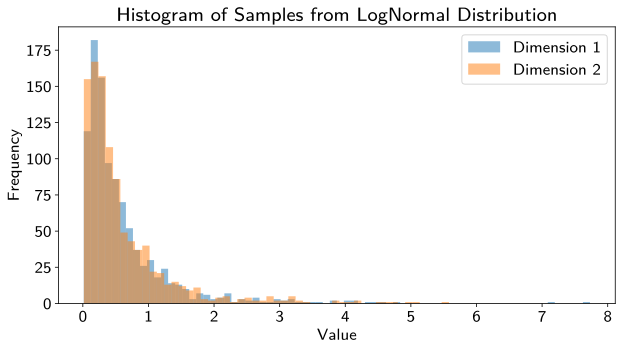

In [29]:
key = jax.random.PRNGKey(
    59
)
n_samples = 1000
sigma_samples = numpyro.sample(
    "sigma", dist.LogNormal(-1, 1).expand([2]), rng_key=key, sample_shape=(n_samples,)
)

plt.figure(figsize=(10, 5))
plt.hist(sigma_samples[:, 0], bins="auto", alpha=0.5, label="Dimension 1")
plt.hist(sigma_samples[:, 1], bins="auto", alpha=0.5, label="Dimension 2")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Samples from LogNormal Distribution")
plt.legend()
plt.show()

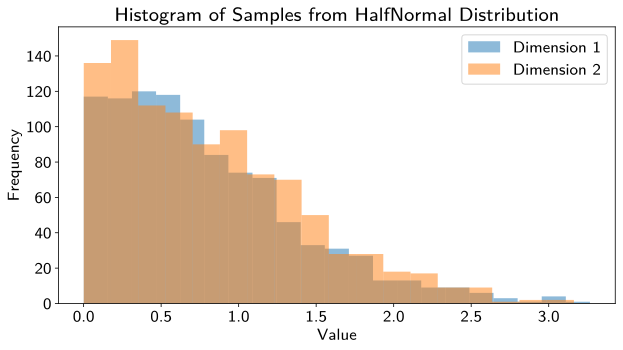

In [30]:
key = jax.random.PRNGKey(
    59
)
n_samples = 1000
sigma_samples = numpyro.sample(
    "sigma", dist.HalfNormal(1).expand([2]), rng_key=key, sample_shape=(n_samples,)
)

plt.figure(figsize=(10, 5))
plt.hist(sigma_samples[:, 0], bins="auto", alpha=0.5, label="Dimension 1")
plt.hist(sigma_samples[:, 1], bins="auto", alpha=0.5, label="Dimension 2")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Samples from HalfNormal Distribution")
plt.legend()
plt.show()

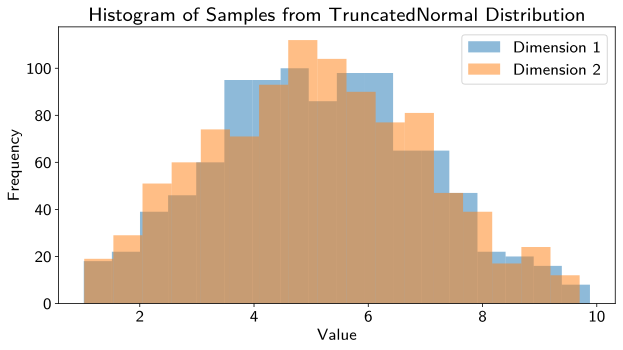

In [31]:
key = jax.random.PRNGKey(
    59
)
n_samples = 1000
sigma_samples = numpyro.sample(
    "sigma", dist.TruncatedNormal(low=1, high=10, loc=5.0, scale=2).expand([2]), rng_key=key, sample_shape=(n_samples,)
    # "sigma", dist.TruncatedNormal(low=.001, high=4, loc=0.7, scale=1).expand([2]), rng_key=key, sample_shape=(n_samples,)
)

plt.figure(figsize=(10, 5))
plt.hist(sigma_samples[:, 0], bins="auto", alpha=0.5, label="Dimension 1")
plt.hist(sigma_samples[:, 1], bins="auto", alpha=0.5, label="Dimension 2")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Samples from TruncatedNormal Distribution")
plt.legend()
plt.show()

In [32]:
def model(N, y=None):
    """
    :param int N: number of measurement times
    :param numpy.ndarray y: measured populations with shape (N, 2)
    """
    # ts = jnp.arange(float(N))
    ts = N
    # z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([2]))
    z_init = numpyro.sample(
        "z_init", dist.TruncatedNormal(low=0.001, high=4, loc=0.7, scale=1).expand([2])
    )
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            # low=5e-1,
            # loc=jnp.array([1.0, 0.05, 1.0, 0.05]),
            # scale=jnp.array([0.5, 0.05, 0.5, 0.05]),
            low=jnp.array([1,1,1,1]),
            high=jnp.array([9, 9, 9, 9]),
            loc=jnp.array([5, 5, 5, 5]),
            scale=jnp.array([2, 2, 2, 2]),
        ),
    )

    solution = solve_lv_model(ts, z_init, theta)
    z = jnp.stack(solution.ys, axis=-1)

    # z = odeint(dz_dt, z_init, ts, theta, rtol=1e-6, atol=1e-5, mxstep=1000)
    positive_mask = z > 1e-10
    log_z = jnp.where(positive_mask, jnp.log(z), -1e10)

    # sigma = numpyro.sample("sigma", dist.LogNormal(-1, 1).expand([2]))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1).expand([2]))
    numpyro.sample("y", dist.LogNormal(log_z, sigma), obs=y)

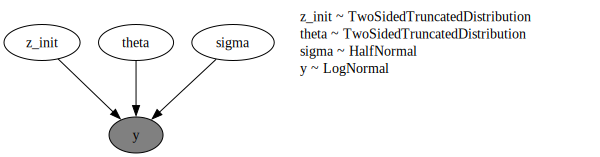

In [33]:
numpyro.render_model(
    model,
    model_args=(
        # data.shape[0],
        time,
        data,
    ),
    render_distributions=True,
    render_params=True,
)

#### Plot priors

In [34]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = jax.random.PRNGKey(0)
rng_key, rng_key_ = jax.random.split(rng_key)

In [35]:
rng_key, rng_key_ = jax.random.split(rng_key)
prior_predictive = Predictive(model, num_samples=1000)
prior_predictions = prior_predictive(rng_key_, time)

In [36]:
idata_prior = az.from_numpyro(
    posterior=None,
    prior=prior_predictions,
    posterior_predictive={"y": prior_predictions["y"]},
)

new_coords = {"y_dim_0": time}
idata_prior.posterior_predictive = idata_prior.posterior_predictive.assign_coords(new_coords)
idata_prior.prior = idata_prior.prior.assign_coords(new_coords)


import xarray as xr

observed_data = xr.Dataset(
    {"y": (["y_dim_0", "y_dim_1"], data)},
    coords={"y_dim_0": time, "y_dim_1": range(data.shape[1])},
)
idata_prior.add_groups(observed_data=observed_data)

In [37]:
idata_prior

Inference data with groups:
	> posterior_predictive
	> prior
	> observed_data

In [38]:
def plot_sample_trajectories(observed_y, samples, time):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)
    
    # Linear scale plot
    ax1.plot(time, observed_y[:, 0], label="prey", color="green", marker=".", ms=12,)
    ax1.plot(time, observed_y[:, 1], label="predator", color="gray", marker=".", ms=12,)
    
    selected_indices = np.random.choice(samples.shape[1], 20, replace=False)
    
    for i in selected_indices:
        ax1.plot(time, samples[0, i, :, 0], color="green", alpha=0.1)
        ax1.plot(time, samples[0, i, :, 1], color="gray", alpha=0.1)
    
    max_val = observed_y.max()
    ax1.set_ylim([-0.01, max_val * 1.2])
    
    # Log scale plot
    ax2.plot(time, observed_y[:, 0], label="prey", color="green", marker=".", ms=12,)
    ax2.plot(time, observed_y[:, 1], label="predator", color="gray", marker=".", ms=12,)
    
    for i in selected_indices:
        ax2.plot(time, samples[0, i, :, 0], color="green", alpha=0.1)
        ax2.plot(time, samples[0, i, :, 1], color="gray", alpha=0.1)
    
    ax2.set_yscale("log")
    
    # Labels and titles
    ax1.set_ylabel("Population number (linear)")
    ax2.set_xlabel("Time (years)")
    ax2.set_ylabel("(log)")
    ax1.legend()
    ax1.set_title("Observed Data and Prior Sample Trajectories")
    
    # Show plot
    plt.tight_layout()
    plt.show()

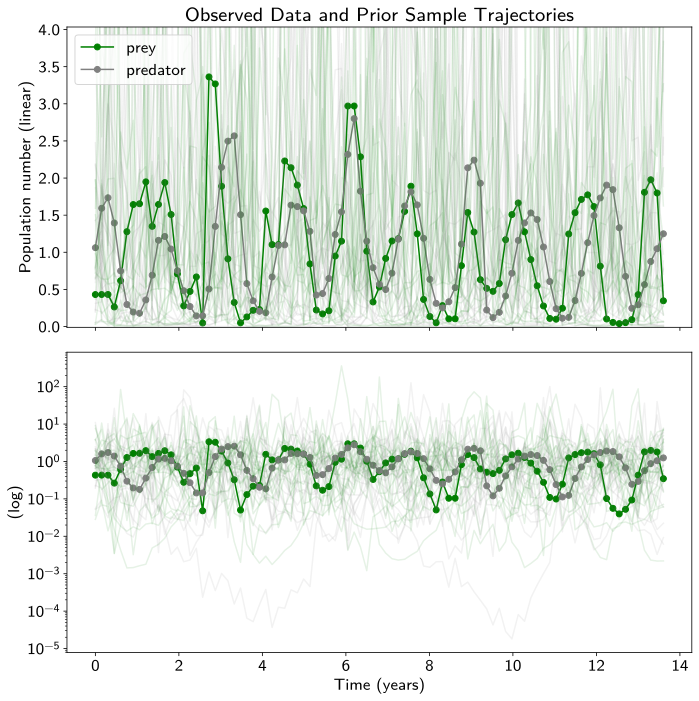

In [39]:
observed_y = idata_prior.observed_data["y"]
prior_samples = idata_prior.prior["y"]
plot_sample_trajectories(observed_y, prior_samples, time)

In [40]:
def plot_sample_phase_portraits(observed_y, samples):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
    
    # Phase portrait for observed data (linear space)
    ax1.plot(observed_y[:, 0], observed_y[:, 1], label="Observed Data", color="black", marker=".", ms=12, linestyle="-")
    
    # Phase portraits for prior samples (linear space)
    selected_indices = np.random.choice(samples.shape[1], 20, replace=False)
    for i in selected_indices:
        ax1.plot(samples[0, i, :, 0], samples[0, i, :, 1], color="gray", alpha=0.2, linestyle="-")
    
    max_val = observed_y.max()
    ax1.set_ylim([-0.01, max_val * 1.2])
    ax1.set_xlim([-0.01, max_val * 1.2])
    ax1.set_xlabel("Prey Population")
    ax1.set_ylabel("Predator Population")
    ax1.legend()
    ax1.set_title("Phase Portrait (linear)")

    # Phase portrait for observed data (log space)
    ax2.loglog(observed_y[:, 0], observed_y[:, 1], label="Observed Data", color="black", marker=".", ms=12, linestyle="-")
    
    # Phase portraits for prior samples (log space)
    for i in selected_indices:
        ax2.loglog(samples[0, i, :, 0], samples[0, i, :, 1], color="gray", alpha=0.2, linestyle="-")
    
    ax2.set_xlabel("Prey Population")
    ax2.set_ylabel("Predator Population")
    ax2.legend()
    ax2.set_title("Phase Portrait (log)")
    
    # Show plot
    plt.tight_layout()
    plt.show()

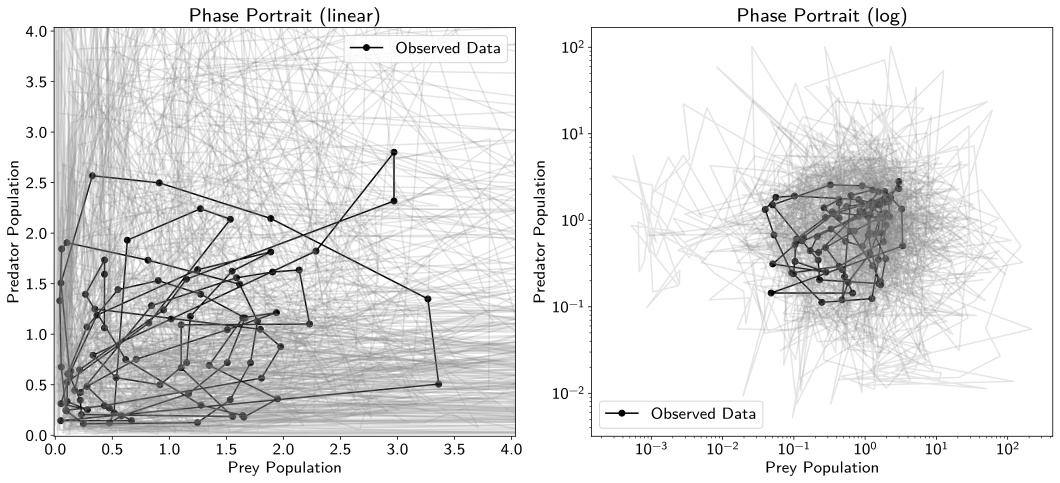

In [41]:
observed_y = idata_prior.observed_data["y"]
prior_samples = idata_prior.prior["y"]
plot_sample_phase_portraits(observed_y, prior_samples)

In [42]:
from scipy.stats import circmean


def plot_population_with_percentiles(observed_y, samples, time):
    red_colors = ["#DCBCBC", "#C79999", "#B97C7C", "#A25050", "#8F2727", "#7C0000"]
    green_colors = ["#BCDCC6", "#99C7A1", "#7CB988", "#50A26A", "#278F4E", "#007C32"]
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)
    
    # observed data
    ax1.plot(time, observed_y[:, 0], label="prey", color="black", marker=".", ms=12,)
    ax1.plot(time, observed_y[:, 1], label="predator", color="gray", marker=".", ms=12,)
    
    # compute percentiles
    percentiles = np.linspace(0, 100, 8)[1:-1]
    
    # percentile bands
    for i, percentile in enumerate(percentiles[::-1]):
        upper = np.percentile(samples[:, :, :, 0], 50 + percentile / 2, axis=1)
        lower = np.percentile(samples[:, :, :, 0], 50 - percentile / 2, axis=1)
        ax1.fill_between(
            time, lower.mean(axis=0), upper.mean(axis=0), color=red_colors[i], alpha=0.2
        )
    
        upper = np.percentile(samples[:, :, :, 1], 50 + percentile / 2, axis=1)
        lower = np.percentile(samples[:, :, :, 1], 50 - percentile / 2, axis=1)
        ax1.fill_between(
            time, lower.mean(axis=0), upper.mean(axis=0), color=green_colors[i], alpha=0.2
        )
    
    # median
    median_0 = np.percentile(samples[:, :, :, 0], 50, axis=1).mean(axis=0)
    median_1 = np.percentile(samples[:, :, :, 1], 50, axis=1).mean(axis=0)
    ax1.plot(time, median_0, color="#7C0000", label="median prey", marker=".", ms=12,)
    ax1.plot(time, median_1, color="#007C32", label="median predator", marker=".", ms=12,)
    
    ax1.set_ylabel("Population number (linear)")
    ax1.legend()
    ax1.set_title("Observed Data with Percentile Bands")
    
    # log scale
    ax2.plot(time, observed_y[:, 0], label="observed prey", color="black", marker=".", ms=12,)
    ax2.plot(time, observed_y[:, 1], label="observed predator", color="gray", marker=".", ms=12,)
    
    for i, percentile in enumerate(percentiles[::-1]):
        upper = np.percentile(samples[:, :, :, 0], 50 + percentile / 2, axis=1)
        lower = np.percentile(samples[:, :, :, 0], 50 - percentile / 2, axis=1)
        ax2.fill_between(
            time, lower.mean(axis=0), upper.mean(axis=0), color=red_colors[i], alpha=0.2
        )
    
        upper = np.percentile(samples[:, :, :, 1], 50 + percentile / 2, axis=1)
        lower = np.percentile(samples[:, :, :, 1], 50 - percentile / 2, axis=1)
        ax2.fill_between(
            time, lower.mean(axis=0), upper.mean(axis=0), color=green_colors[i], alpha=0.2
        )
    
    ax2.plot(time, median_0, color="#7C0000", label="median prey", marker=".", ms=12,)
    ax2.plot(time, median_1, color="#007C32", label="median predator", marker=".", ms=12,)
    
    ax2.set_yscale("log")
    ax2.set_xlabel("Time (years)")
    ax2.set_ylabel("(log)")
   
    plt.tight_layout()
    plt.show()

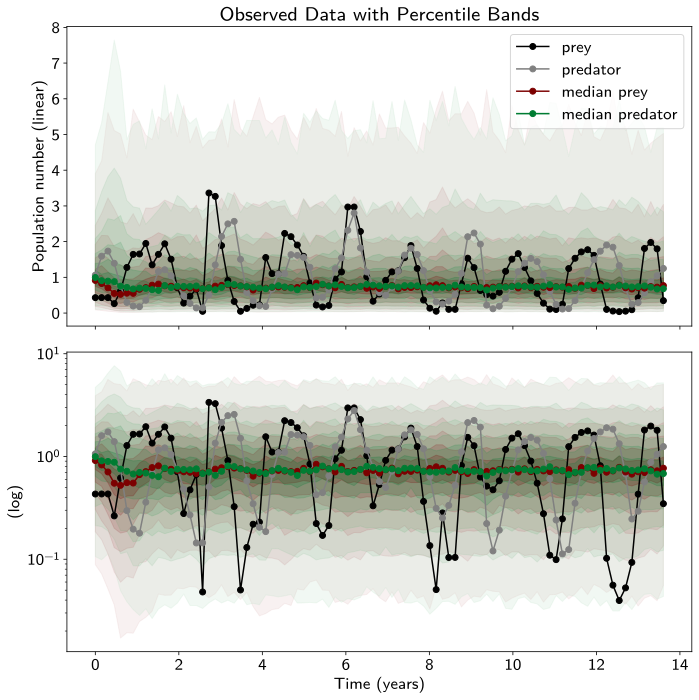

In [43]:
colors = ["#DCBCBC", "#C79999", "#B97C7C", "#A25050", "#8F2727", "#7C0000"]
observed_y = idata_prior.observed_data["y"]
prior_samples = idata_prior.prior["y"]

plot_population_with_percentiles(observed_y, prior_samples, time)


In [44]:
def plot_percentile_bands(prior_samples, observed_y, variable_index, ax):
    # Define colors
    colors = ["#BCDCC6", "#99C7A1", "#7CB988", "#50A26A", "#278F4E", "#007C32"]

    # compute percentiles
    percentiles = np.linspace(0, 100, 8)[1:-1]

    # observed data
    ax[0].plot(time, observed_y[:, variable_index], color="gray", label="observed", marker=".", ms=12,)

    # percentile bands
    for i, percentile in enumerate(percentiles[::-1]):
        upper = np.percentile(
            prior_samples[:, :, :, variable_index], 50 + percentile / 2, axis=1
        )
        lower = np.percentile(
            prior_samples[:, :, :, variable_index], 50 - percentile / 2, axis=1
        )
        ax[0].fill_between(
            time, lower.mean(axis=0), upper.mean(axis=0), color=colors[i], alpha=0.6
        )

    # median
    median = np.percentile(prior_samples[:, :, :, variable_index], 50, axis=1).mean(
        axis=0
    )
    ax[0].plot(time, median, color="#007C32", label="median", marker=".", ms=12,)

    # linear scale plot
    ax[0].set_ylabel("Population number (linear)")
    ax[0].legend()
    ax[0].set_title(
        f"Observed Data with Percentile Bands ({'Prey' if variable_index == 0 else 'Predator'})"
    )

    # log scale plot
    ax[1].plot(time, observed_y[:, variable_index], color="gray", label="observed", marker=".", ms=12,)

    for i, percentile in enumerate(percentiles[::-1]):
        upper = np.percentile(
            prior_samples[:, :, :, variable_index], 50 + percentile / 2, axis=1
        )
        lower = np.percentile(
            prior_samples[:, :, :, variable_index], 50 - percentile / 2, axis=1
        )
        ax[1].fill_between(
            time, lower.mean(axis=0), upper.mean(axis=0), color=colors[i], alpha=0.6
        )

    ax[1].plot(time, median, color="#007C32", label="median", marker=".", ms=12,)

    # Set labels for the log scale plot
    ax[1].set_yscale("log")
    ax[1].set_xlabel("Time (years)")
    ax[1].set_ylabel("(log)")

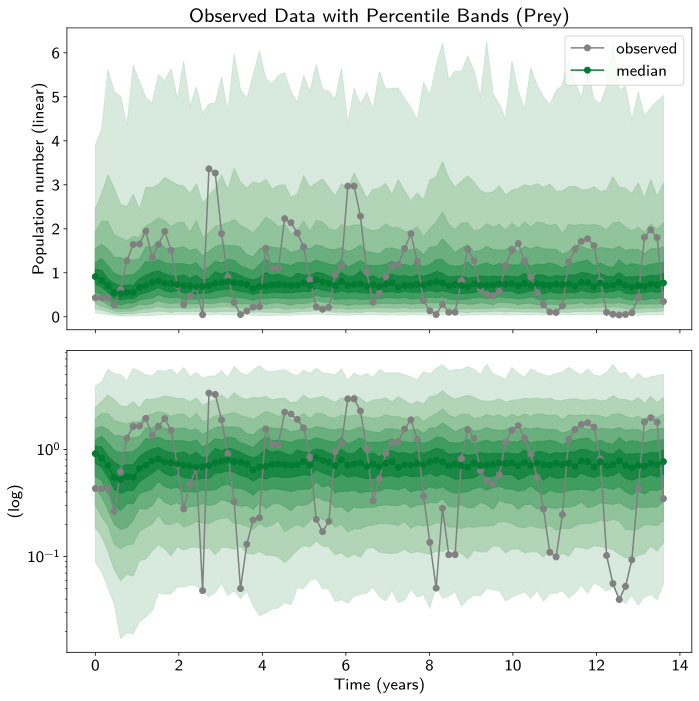

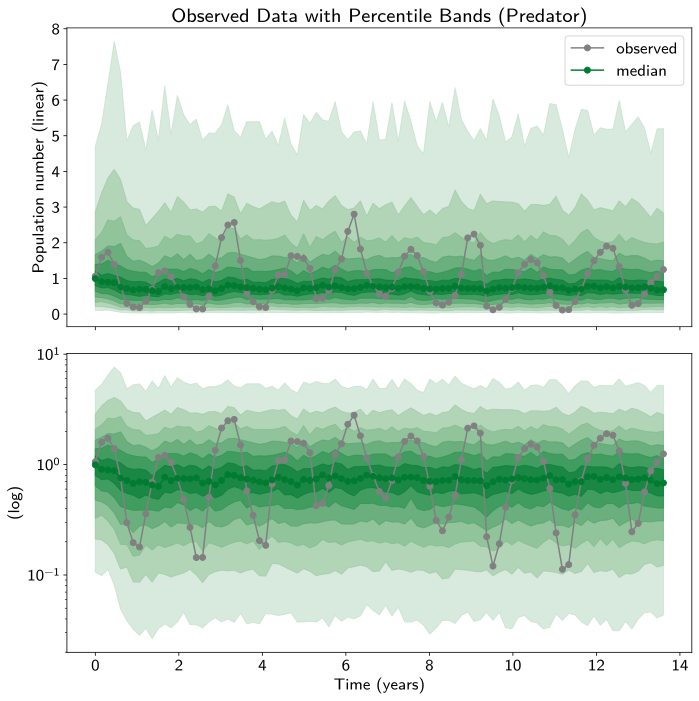

In [45]:
for variable_index, name in enumerate(["Prey", "Predator"]):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)
    plot_percentile_bands(prior_samples, observed_y, variable_index, ax)
    plt.tight_layout()
    plt.show()

In [46]:
idata_prior

Inference data with groups:
	> posterior_predictive
	> prior
	> observed_data

In [47]:
light_gray = (0.7, 0.7, 0.7)

array([<Axes: title={'center': 'z_init\n0'}>,
       <Axes: title={'center': 'z_init\n1'}>], dtype=object)

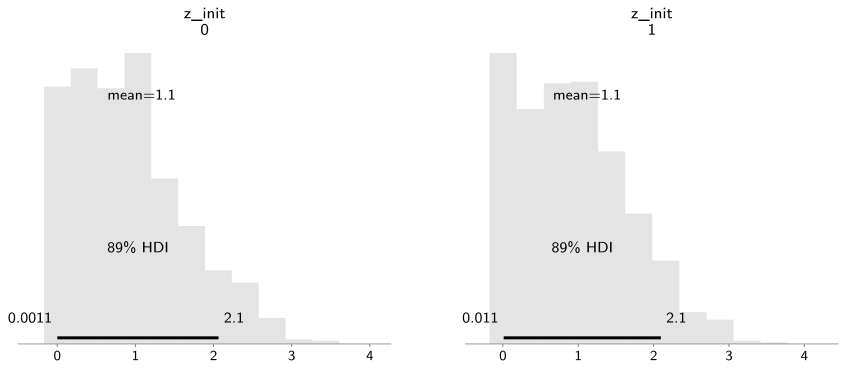

In [48]:
az.plot_posterior(
    idata_prior,
    var_names=["z_init"],
    grid=(1, 2),
    group="prior",
    kind="hist",
    round_to=2,
    hdi_prob=0.89,
    color=light_gray,
)

array([[<Axes: title={'center': 'theta\n0'}>,
        <Axes: title={'center': 'theta\n1'}>],
       [<Axes: title={'center': 'theta\n2'}>,
        <Axes: title={'center': 'theta\n3'}>]], dtype=object)

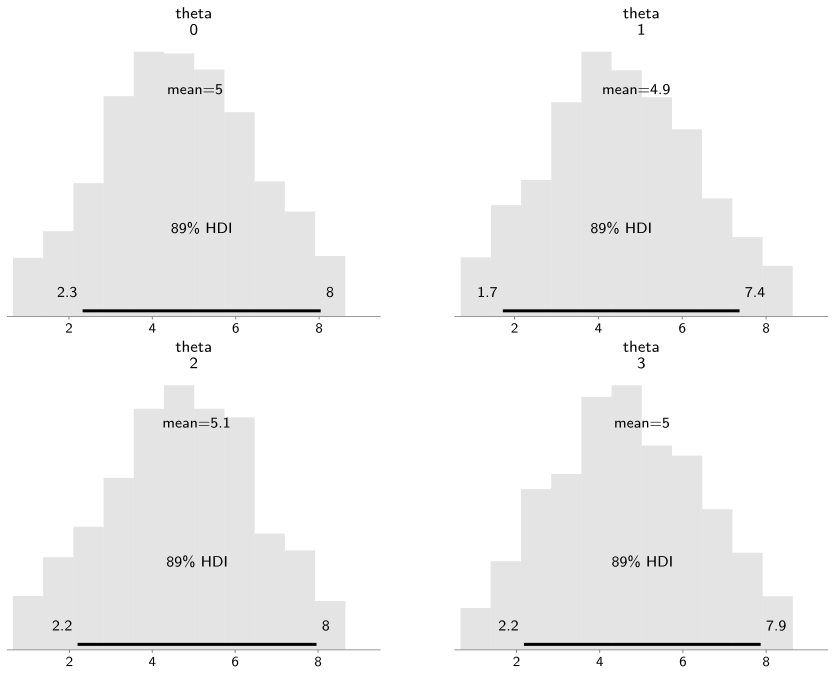

In [49]:
az.plot_posterior(
    idata_prior,
    var_names=["theta"],
    grid=(2, 2),
    group="prior",
    kind="hist",
    round_to=2,
    hdi_prob=0.89,
    color=light_gray,
)

array([<Axes: title={'center': 'sigma\n0'}>,
       <Axes: title={'center': 'sigma\n1'}>], dtype=object)

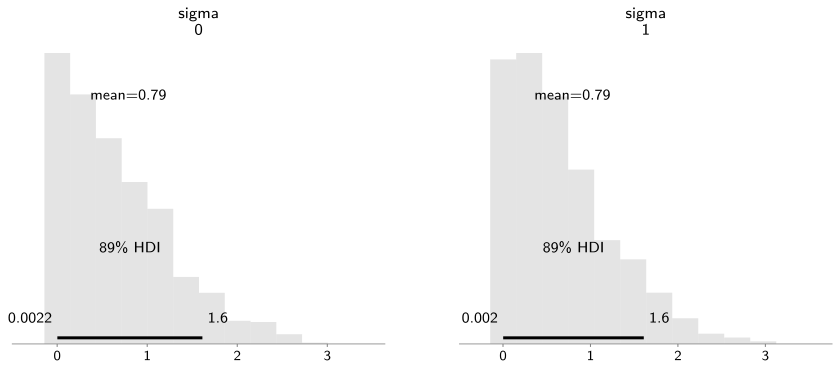

In [50]:
az.plot_posterior(
    idata_prior,
    var_names=["sigma"],
    group="prior",
    kind="hist",
    round_to=2,
    hdi_prob=0.89,
    color=light_gray,
)

### Fit model

In [51]:
R = 1000

In [52]:
kernel = NUTS(model, dense_mass=True)
mcmc = MCMC(
    kernel,
    num_warmup=1000,
    num_samples=R,
    num_chains=1,
    chain_method="vectorized",
    progress_bar=True,
)

In [53]:
mcmc.run(rng_key_, N=time, y=data)

sample: 100%|██████████| 2000/2000 [02:53<00:00, 11.50it/s, 15 steps of size 2.15e-01. acc. prob=0.96]


In [54]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma[0]      1.06      0.08      1.05      0.93      1.17   1214.58      1.00
  sigma[1]      0.78      0.06      0.77      0.68      0.87   1175.35      1.00
  theta[0]      4.25      0.76      4.24      3.02      5.43    416.49      1.00
  theta[1]      5.24      1.02      5.16      3.65      6.98    498.15      1.00
  theta[2]      3.29      0.60      3.19      2.45      4.33    428.10      1.00
  theta[3]      4.83      1.01      4.74      3.11      6.40    481.11      1.00
 z_init[0]      0.43      0.09      0.42      0.28      0.56    620.94      1.00
 z_init[1]      1.12      0.16      1.11      0.83      1.35    694.96      1.00

Number of divergences: 0


In [55]:
posterior_samples = mcmc.get_samples(group_by_chain=False)

In [56]:
rng_key, rng_key_ = jax.random.split(rng_key)
posterior_predictive = Predictive(model, posterior_samples)
posterior_predictions = posterior_predictive(rng_key_, time)

In [57]:
[v.shape for k, v in posterior_predictions.items()]

[(1000, 91, 2)]

In [58]:
rng_key, rng_key_ = jax.random.split(rng_key)
prior_predictive = Predictive(model, num_samples=1000)
prior_predictions = prior_predictive(rng_key_, time)

In [59]:
[v.shape for k, v in prior_predictions.items()]

[(1000, 2), (1000, 4), (1000, 91, 2), (1000, 2)]

### Organize output data

In [60]:
idata_posterior = az.from_numpyro(
    mcmc,
    prior=prior_predictions,
    posterior_predictive=posterior_predictions,
)

In [61]:
idata_posterior

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

### Evaluate model

#### Plot autocorrelation to evaluate MCMC chain mixing

array([[<Axes: title={'center': 'sigma\n0, 0'}>,
        <Axes: title={'center': 'sigma\n0, 1'}>,
        <Axes: title={'center': 'theta\n0, 0'}>],
       [<Axes: title={'center': 'theta\n0, 1'}>,
        <Axes: title={'center': 'theta\n0, 2'}>,
        <Axes: title={'center': 'theta\n0, 3'}>]], dtype=object)

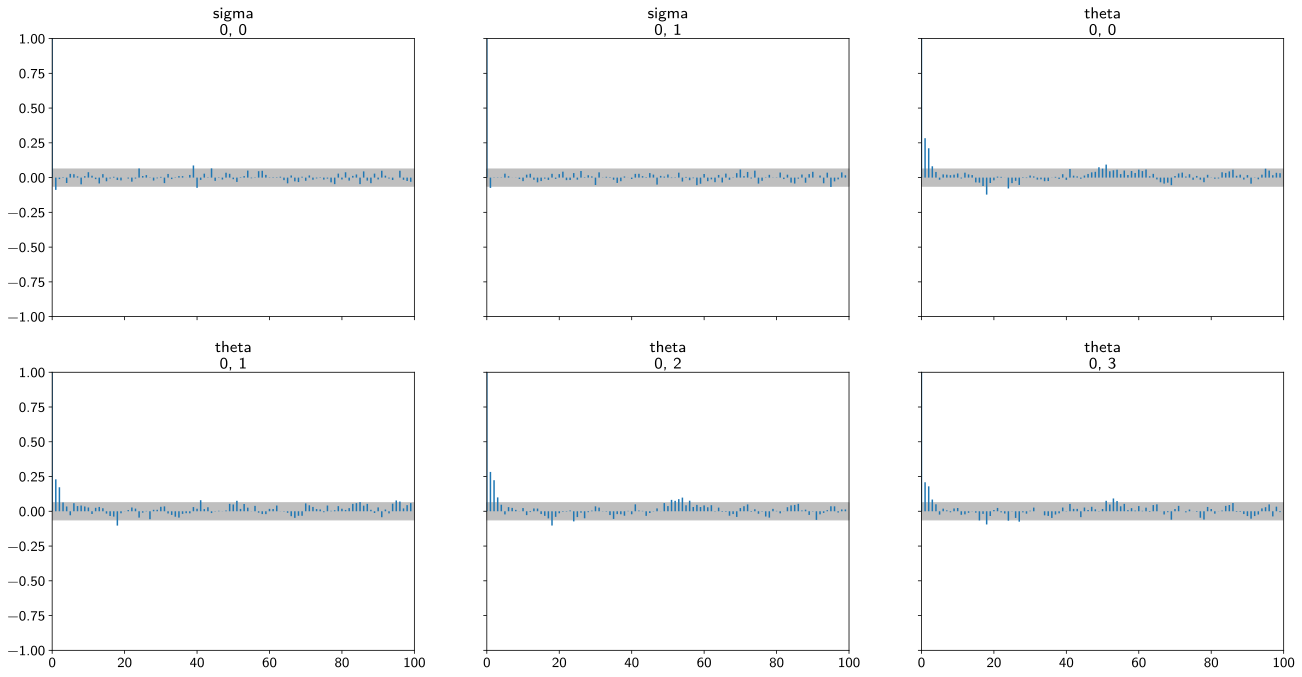

In [62]:
# with model:
az.plot_autocorr(idata_posterior, var_names=["sigma", "theta"])

#### Plot prior and posterior predictive distributions

In [63]:
idata_prior

Inference data with groups:
	> posterior_predictive
	> prior
	> observed_data

In [64]:
idata_posterior

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [65]:
type(prior_samples)

xarray.core.dataarray.DataArray

In [66]:
type(posterior_predictive)

numpyro.infer.util.Predictive

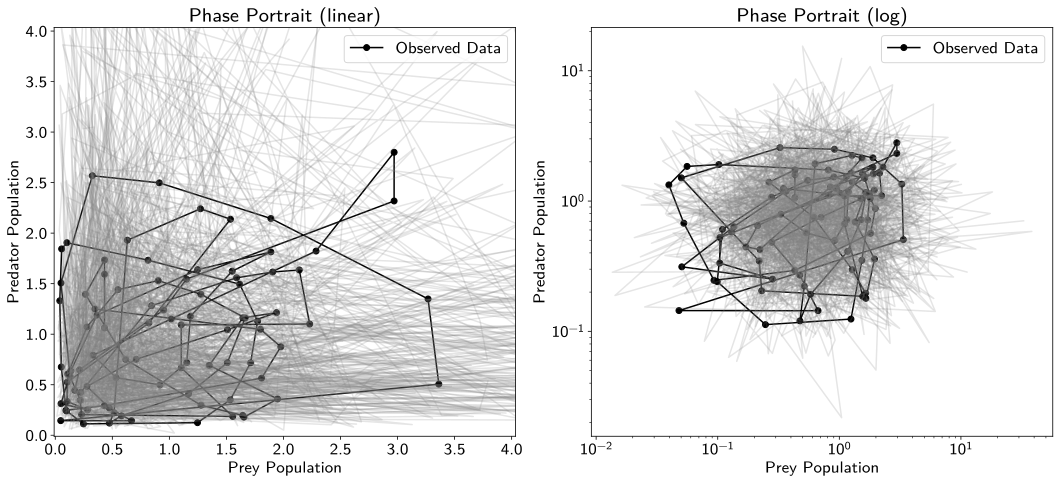

In [67]:
plot_sample_phase_portraits(observed_y, idata_posterior.posterior_predictive["y"])

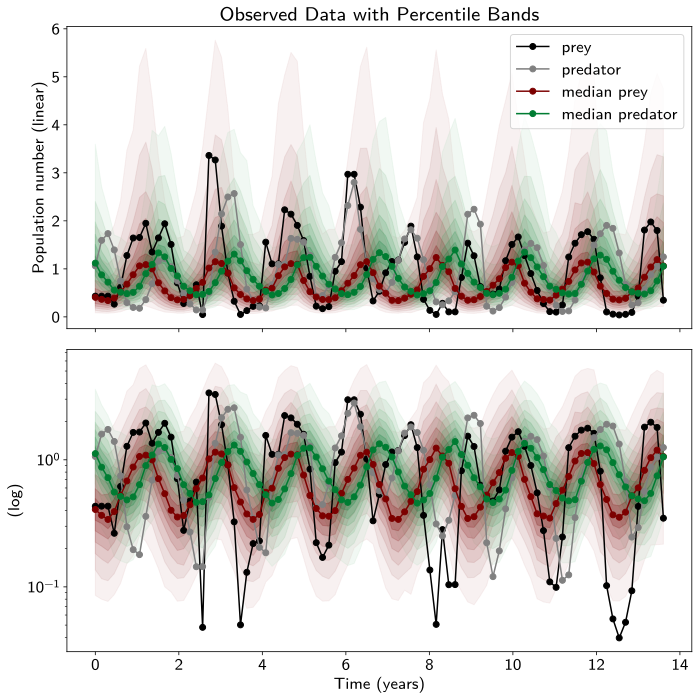

In [68]:
plot_population_with_percentiles(
    observed_y, 
    idata_posterior.posterior_predictive["y"], 
    time, 
)

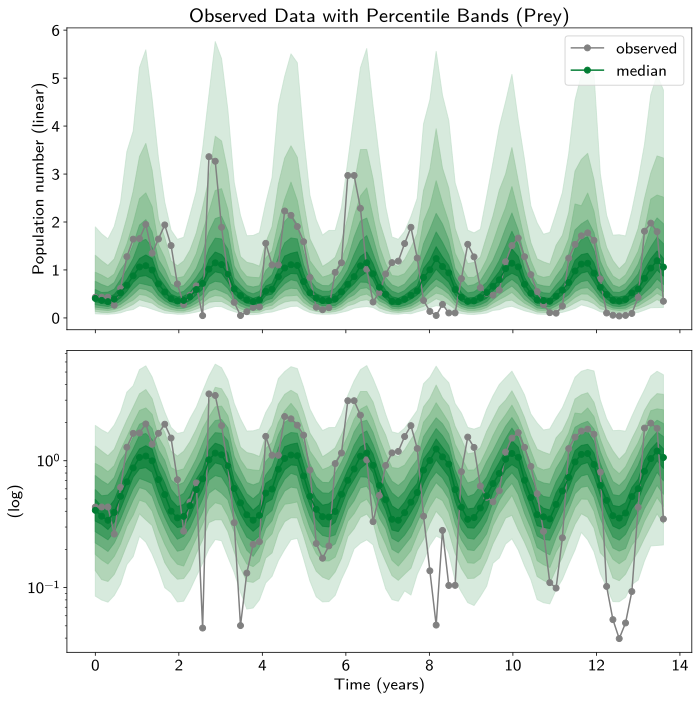

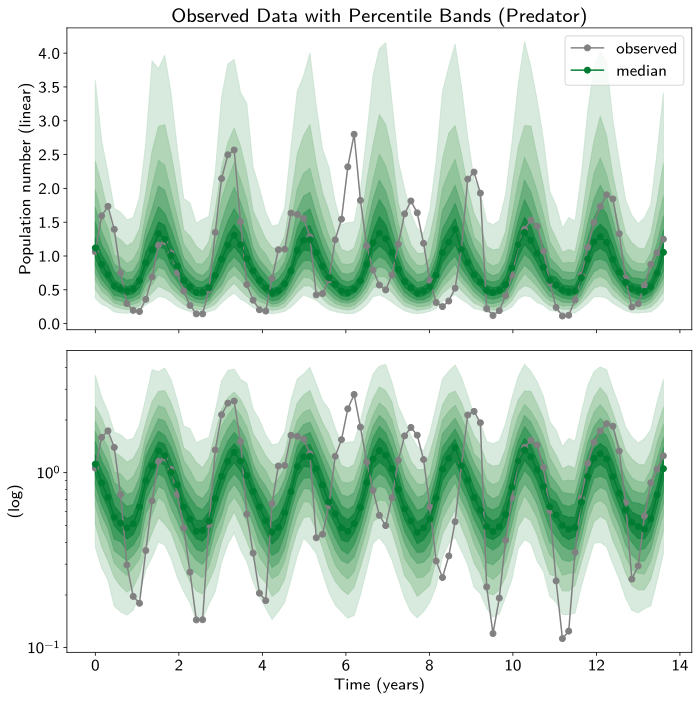

In [69]:
for variable_index, name in enumerate(["Prey", "Predator"]):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)
    plot_percentile_bands(idata_posterior.posterior_predictive["y"], observed_y, variable_index, ax)
    plt.tight_layout()
    plt.show()

In [70]:
idata_prior

Inference data with groups:
	> posterior_predictive
	> prior
	> observed_data

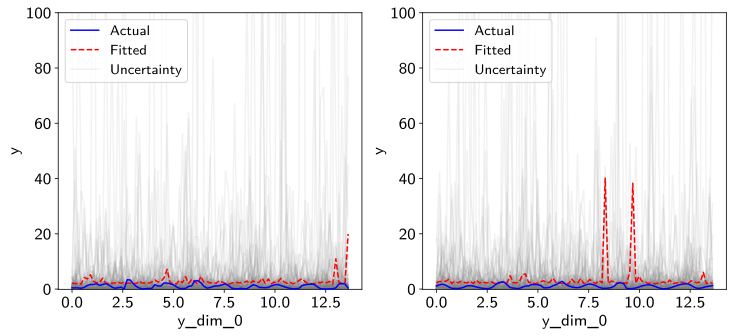

In [71]:
ax_ppc = az.plot_ts(idata_prior, y="y", plot_dim="y_dim_0")
for ax in ax_ppc[0]:
    # ax.set_xlim([-1, 93])
    ax.set_ylim([-0.1, 100])

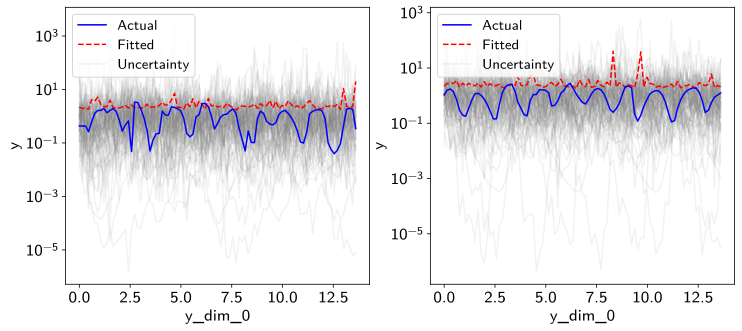

In [72]:
ax_ppc_log = az.plot_ts(idata_prior, y="y", plot_dim="y_dim_0")
for ax in ax_ppc_log[0]:
    ax.set_yscale("log")

In [73]:
idata_posterior

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

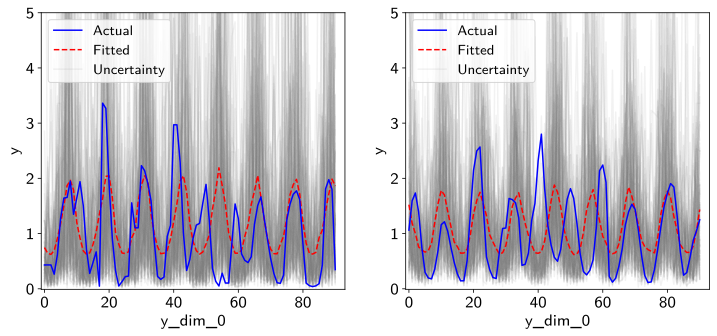

In [74]:
ax_postpc = az.plot_ts(idata_posterior, y="y", plot_dim="y_dim_0")
for ax in ax_postpc[0]:
    ax.set_xlim([-1, 93])
    ax.set_ylim([-0.01, 5])

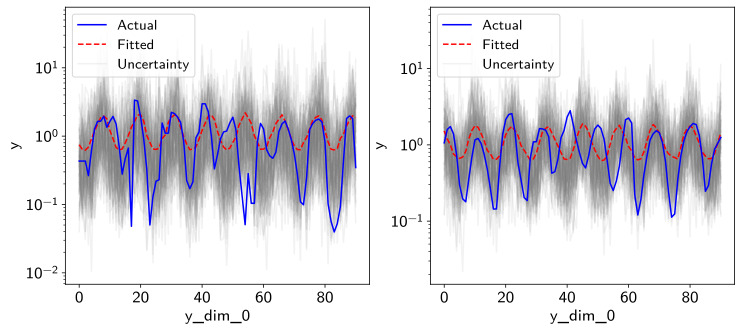

In [75]:
ax_postpc_log = az.plot_ts(idata_posterior, y="y", plot_dim="y_dim_0")
for ax in ax_postpc_log[0]:
    ax.set_yscale("log")

#### Characterize posterior distribution

array([<Axes: title={'center': 'sigma\n0'}>,
       <Axes: title={'center': 'sigma\n1'}>], dtype=object)

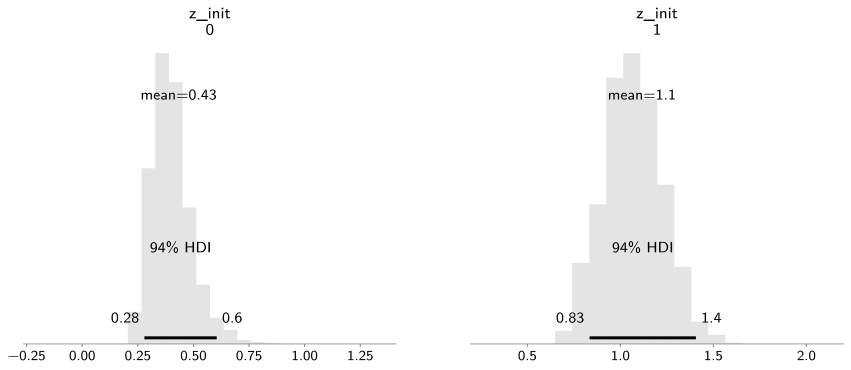

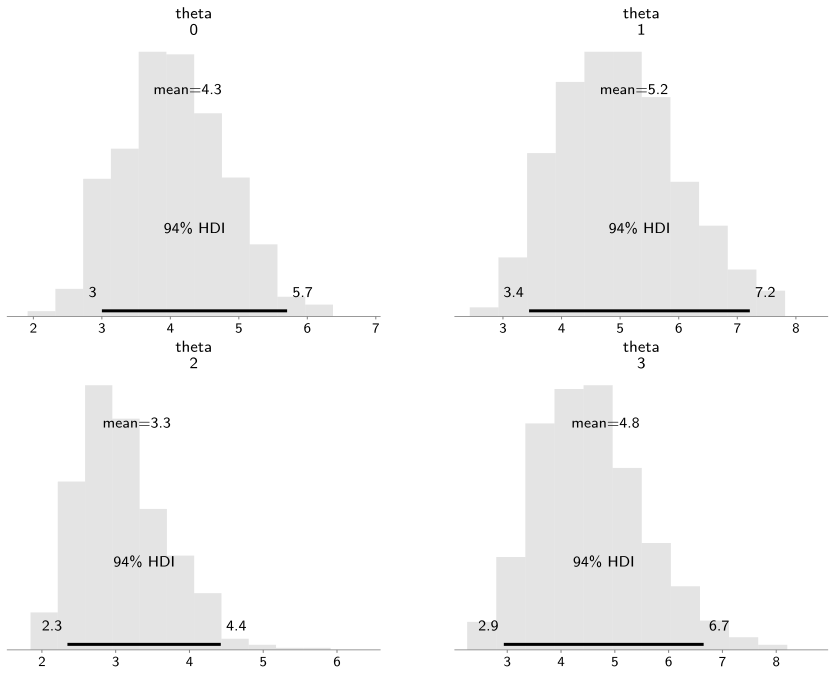

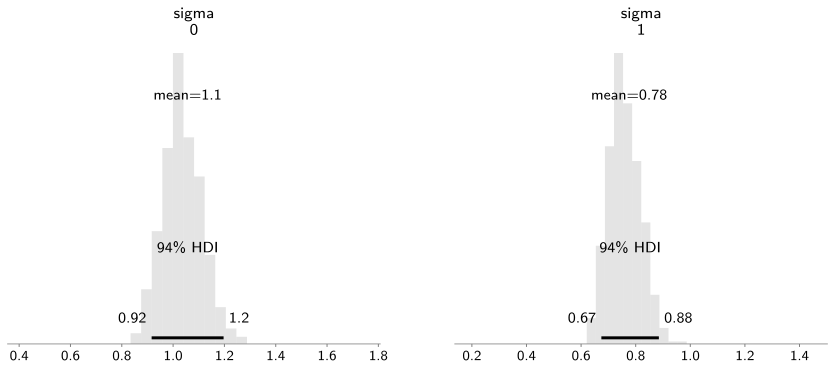

In [76]:
az.plot_posterior(
    idata_posterior, var_names=["z_init"], grid=(1, 2), kind="hist", color=light_gray
)
az.plot_posterior(
    idata_posterior, var_names=["theta"], grid=(2, 2), kind="hist", color=light_gray
)
az.plot_posterior(
    idata_posterior, var_names=["sigma"], grid=(1, 2), kind="hist", color=light_gray
)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

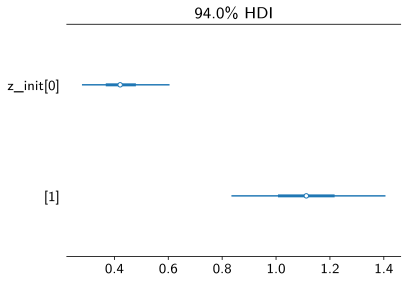

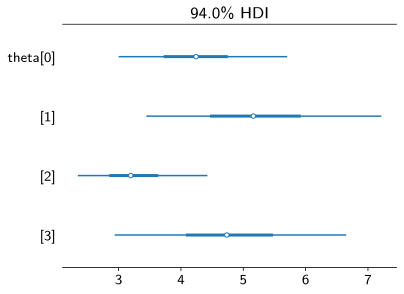

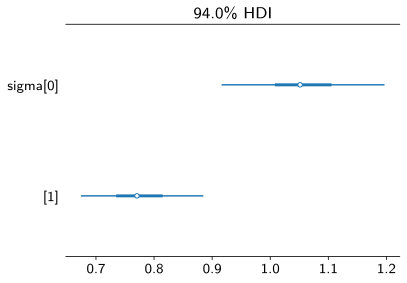

In [77]:
az.plot_forest(idata_posterior, var_names=["z_init"])
az.plot_forest(idata_posterior, var_names=["theta"])
az.plot_forest(idata_posterior, var_names=["sigma"])

array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'z_init'}>,
        <Axes: title={'center': 'z_init'}>]], dtype=object)

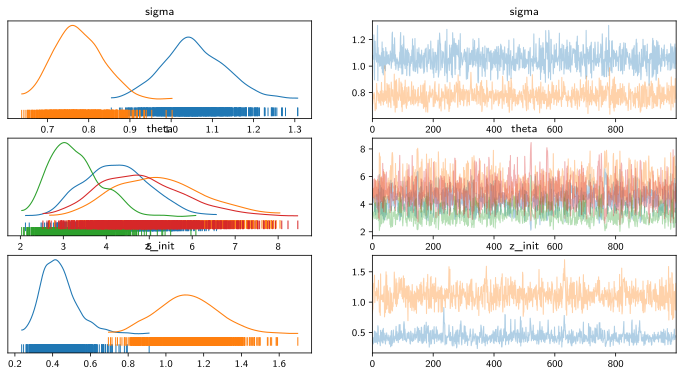

In [78]:
az.plot_trace(idata_posterior, rug=True)

In [79]:
end_time = time_module.time()
total_time = end_time - start_time
print(f"Total runtime: {total_time/60:0.2f} minutes")

Total runtime: 3.64 minutes
